Nome: Joel Alcídio Varela Mendonça

RA: 139884

Curso:Doutorando Eng. Elétrica



# Ex06 - Desafio de classificação: detecção de tumores no cérebro

O objetivo deste desafio é classificar um conjunto de imagens 2D de cérebros saudáveis e cérebros contendo tumores. As imagens estão no diretório **Dados/Ex06/Brain_Tumor_Dataset**, subdivididas em conjuntos de treino, validação e teste. Note que as labels do conjunto de teste não estão disponíveis!

Sinta-se livre para utilizar qualquer classificador/técnica que desejar, mas lembre-se de justificar suas escolhas! A ideia é que você tente utilizar tudo que foi aprendido até aqui para obter um classificador com o melhor desempenho possível. Após definir o seu modelo final, você deve obter as predições para o conjunto de teste. Assim, além deste notebook com seus experimentos e comentários, você deve enviar também um arquivo com as suas predições para o conjunto de teste. Nas instruções do exercício no classroom você vai encontrar informações mais específicas sobre como enviar suas predições para o conjunto de teste.

**ATENÇÃO**: a nota deste exercício não vai se basear no desempenho final do seu classificador! Mais detalhes sobre os critérios de avaliação serão postados no classroom em breve.

Sugestões:
- Aplique técnicas de data augmentation;
- Tente utilizar modelos pré-treinados e técnicas de transfer learning;
- Tente modificar os hiperparâmetros (Optimizer, Learning-Rate, Número de Épocas, Tamanho do Batch, etc) para obter modelos com melhor desempenho;
- Utilize alguma ferramenta para acompanhamento e visualização das curvas de treino e validação (loss e acurácia). Por ex.: [Neptune](https://neptune.ai) ou [Wandb](https://wandb.ai/). Compare as diferentes versões de modelos utilizadas.

In [13]:
# Instalando bibliotecas no Colab
!pip install pytorch-lightning torchinfo torchmetrics --quiet
!pip install pyngrok
!pip install -U 'mlflow>=1.0.0' --quiet
!pip install neptune --quiet

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 29.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 29.0


In [14]:
# Importando as bibliotecas que serão utilizadas
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import random
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import datasets, models
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchmetrics import Accuracy
import torchinfo
from torchsummary import summary
import multiprocessing as mp
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%load_ext tensorboard

# Definindo o nome da pasta compartilhada
# IMPORTANTE: substitua "NOME_DA_PASTA_COMPARTILHADA" abaixo pelo nome correspondente
pasta_compartilhada = "NOME_DA_PASTA_COMPARTILHADA"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [15]:

# Conexão do colab com o drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
# Os hiperparametros da minha rede

hparams = {"experiment_name": "Test_ResNet_1",  # experiment name identifies the run for later
           "max_epochs": 50,  # number of epochs to train
           "batch_size_train": 32,  # size of batch
           "batch_size_val": 32,  # size of batch
           "nworkers": mp.cpu_count(),  # number of workers to use in parallel loading
           "nout": 2,  # number of classes
           "nin": 3,  # number of channels of the input image
           "lr": 1e-5,  # learning rate
           "wd": 1e-5,  # weight decay for optimizer
           "cpu": False,  # forces using the CPU
           }

'''
Estamos tentando distinguir entre imagens pertencentes a dois grupos diferentes: carcinoma basocelular (rótulo 1) e melanoma (rótulo 4).
Cada imagem é atribuída a uma dessas duas classes: rótulo 1 ou rótulo 4. Para representar o número de classes, utilizamos "nout" = 2.

Além disso, como estamos lidando com imagens coloridas no formato RGB, onde cada pixel é representado por três valores correspondentes às
intensidades de vermelho, verde e azul, o parâmetro que representa o número de canais, "nin", é definido como três.
'''


'\nEstamos tentando distinguir entre imagens pertencentes a dois grupos diferentes: carcinoma basocelular (rótulo 1) e melanoma (rótulo 4).\nCada imagem é atribuída a uma dessas duas classes: rótulo 1 ou rótulo 4. Para representar o número de classes, utilizamos "nout" = 2.\n\nAlém disso, como estamos lidando com imagens coloridas no formato RGB, onde cada pixel é representado por três valores correspondentes às\nintensidades de vermelho, verde e azul, o parâmetro que representa o número de canais, "nin", é definido como três.\n'

In [18]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
'''
Carrega e pré-processa conjuntos de dados de treinamento, validação e teste para
um problema de classificação de imagens.

'''
# Caminho para os dados de treinamento e validação
train_data_dir = f"gdrive/MyDrive/Dados/Ex06/Brain_Tumor_Dataset/train/"
val_data_dir = f"gdrive/MyDrive/Dados/Ex06/Brain_Tumor_Dataset/val/"
test_data_dir = f"gdrive/MyDrive/Dados/Ex06/Brain_Tumor_Dataset/test/"

# Transformação para converter as imagens em tensores
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensiona as imagens para 224x224 pixels
    transforms.ToTensor(),           # Converte as imagens para tensores
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normaliza os pixels das imagens
])
# Carrega os dados de treinamento, validação e teste
train_data = datasets.ImageFolder(root=train_data_dir, transform=transform)
val_data = datasets.ImageFolder(root=val_data_dir, transform=transform)
test_data = datasets.ImageFolder(root=val_data_dir, transform=transform)

#data_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=False)

'''
data_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
# Itera sobre o primeiro lote de dados 'data_loader'
images, labels = next(iter(data_loader))
image = transforms.ToPILImage()(images[i])
plt.imshow(np.array(image))

'''







'''
images.permute(1, 2, 0).numpy()
#plt.imshow(images.permute(1, 2, 0).numpy())


print(labels)
indices_1_tr_img = np.where(np.array(labels) == 1)[0]
print(len(indices_1_tr_img))
train_image_1 = []
for i in indices_1_tr_img:
  train_image_1.append(images[i])



for i, label in enumerate(labels):
  if label == 0:
      print(f'O rótulo da imagem {i} é 0.')
'''
'''
def show_image(dataset, size):

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=size, shuffle=False)
  # Itera sobre o primeiro lote de dados 'data_loader'
  images, labels = next(iter(data_loader))


  print("Shape do batch:", images.shape)
  img_grid = make_grid(images, nrow=10, pad_value=1)
  fig = plt.figure(figsize=(10,10))
  plt.imshow(img_grid.permute(1, 2, 0).numpy())
  plt.title(f'Labels: {labels}')
  plt.axis('off')
  plt.show()


show_image(train_data, 10)
'''

'\ndef show_image(dataset, size):\n\n  data_loader = torch.utils.data.DataLoader(dataset, batch_size=size, shuffle=False)\n  # Itera sobre o primeiro lote de dados \'data_loader\'\n  images, labels = next(iter(data_loader))\n\n\n  print("Shape do batch:", images.shape)\n  img_grid = make_grid(images, nrow=10, pad_value=1)\n  fig = plt.figure(figsize=(10,10))\n  plt.imshow(img_grid.permute(1, 2, 0).numpy())\n  plt.title(f\'Labels: {labels}\')\n  plt.axis(\'off\')\n  plt.show()\n\n\nshow_image(train_data, 10)\n'

In [ ]:
#data_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

def augmentation_images(_dataset_, num_aug_img, lbl):
  data_loader = torch.utils.data.DataLoader(_dataset_, batch_size=10, shuffle=True)
  print(f'O data_loader contém {len(data_loader.dataset)} imagens.')


  augmentation = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.5), # Inverte horizontalmente a imagem com probabilidade de 50%
      transforms.RandomRotation(degrees=(-45, 45)), # Rotaciona a imagem por um ângulo aleatório dentro do intervalo [-45, 45] graus
      #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Ajusta aleatoriamente o brilho, contraste, saturação e matiz da imagem
      #transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)), # Aplica um desfoque gaussiano à imagem com um kernel de tamanho 5x5 e desvio padrão de 2
      #transforms.Resize((224, 224)),
      # Adicione mais transformações conforme necessário
  ])

  # Inicialize uma lista para armazenar as imagens aumentadas
  augmented_images = []

  for images, labels in data_loader:
    for image, label in zip(images, labels):
          if label == lbl and len(augmented_images) < num_aug_img:
              augmented_image = augmentation(image)
              augmented_images.append((augmented_image, label))

  return augmented_images



In [ ]:
len(augmentation_images(train_data, 37, 0)[1])

O data_loader contém 143 imagens.


2

In [ ]:
aug_img = augmentation_images(train_data, 37, 0)

augmented_dataloader = torch.utils.data.DataLoader(aug_img, batch_size=10)
print(f'O augmented_dataloader contém {len(augmented_dataloader.dataset)} imagens.')

#combined_data_set = train_data + aug_img
#combined_data_set = torch.utils.data.ConcatDataset([train_data, aug_img])

#combined_data_set = torch.utils.data.ConcatDataset([aug_img[1].dataset, augmented_dataloader.dataset])

#combined_dataloader = torch.utils.data.ConcatDataset([data_loader.dataset, augmented_dataloader.dataset])

combined_data_loader = torch.utils.data.DataLoader(combined_data_set, batch_size=20, shuffle=False)
print(f'O combined_data_loader contém {len(combined_data_loader.dataset)} imagens.')


O data_loader contém 143 imagens.
O augmented_dataloader contém 37 imagens.
O combined_data_loader contém 180 imagens.


In [ ]:
aug_img = augmentation_images(train_data, 37, 0)

combined_data_set = torch.utils.data.ConcatDataset([train_data, aug_img])


O data_loader contém 143 imagens.


In [ ]:
combined_data_set

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 143
    Root location: gdrive/MyDrive/Dados/Ex06/Brain_Tumor_Dataset/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
def show_image(dataset, size):

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=size, shuffle=False)

  # Itera sobre o primeiro lote de dados 'data_loader'
  images, labels = next(iter(data_loader))


  print("Shape do batch:", images.shape)
  img_grid = make_grid(images, nrow=10, pad_value=1)
  fig = plt.figure(figsize=(10,10))
  plt.imshow(img_grid.permute(1, 2, 0).numpy())
  plt.title(f'Labels: {labels}')
  plt.axis('off')
  plt.show()


show_image(combined_data_set, 80)

NameError: name 'combined_data_set' is not defined

In [19]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Suponha que train_data seja um ImageFolder contendo imagens e rótulos

# Função para realizar augmentation em imagens
def augmentation_images(_dataset_, num_aug_img, lbl):
    # Inicialize uma lista para armazenar as imagens aumentadas
    augmented_images = []

    # Contador para acompanhar o número de imagens aumentadas
    augmented_count = 0

    # Transformações de aumento de dados desejadas
    augmentation = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.5), # Inverte horizontalmente a imagem com probabilidade de 50%
      transforms.RandomRotation(degrees=(-45, 45)), # Rotaciona a imagem por um ângulo aleatório dentro do intervalo [-45, 45] graus
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Ajusta aleatoriamente o brilho, contraste, saturação e matiz da imagem
      transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)), # Aplica um desfoque gaussiano à imagem com um kernel de tamanho 5x5 e desvio padrão de 2
    ])

    # Iterar sobre o dataset para encontrar imagens com o rótulo desejado
    for image, label in _dataset_:
        if label == lbl and augmented_count < num_aug_img:
            # Aplicar as transformações de aumento na imagem
            augmented_image = augmentation(image)
            augmented_images.append((augmented_image, label))
            augmented_count += 1

    return augmented_images

# Suponha que train_data seja o seu conjunto de dados original
# Suponha também que você queira aumentar 10 imagens com rótulo 0
num_augmented_images = 37
label_to_augment = 0

# Aplicar augmentation nas imagens
augmented_images_train = augmentation_images(train_data, num_augmented_images, label_to_augment)
augmented_images_val = augmentation_images(val_data, 20, label_to_augment)

# Criar um novo conjunto de dados que contém tanto as imagens originais quanto as imagens aumentadas
combined_data_set_train = torch.utils.data.ConcatDataset([train_data, augmented_images_train])
combined_data_set_val = torch.utils.data.ConcatDataset([val_data, augmented_images_val])

# Agora combined_data_set contém as imagens originais e as imagens aumentadas com rótulo 0


Shape do batch: torch.Size([82, 3, 224, 224])


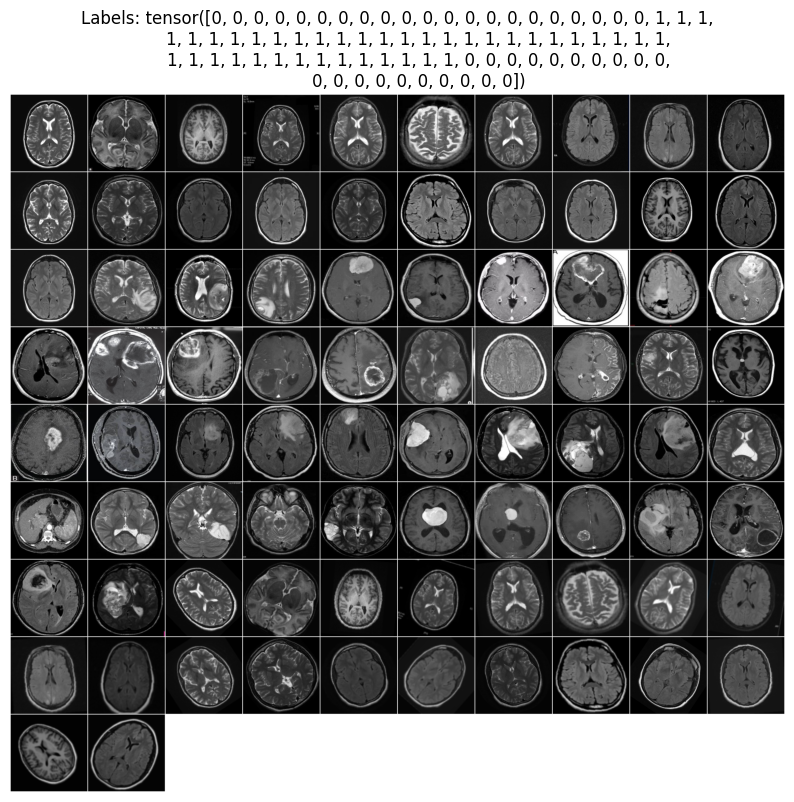

In [20]:
def show_image(dataset, size):

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=size, shuffle=False)

  # Itera sobre o primeiro lote de dados 'data_loader'
  images, labels = next(iter(data_loader))


  print("Shape do batch:", images.shape)
  img_grid = make_grid(images, nrow=10, pad_value=1)
  fig = plt.figure(figsize=(10,10))
  plt.imshow(img_grid.permute(1, 2, 0).numpy())
  plt.title(f'Labels: {labels}')
  plt.axis('off')
  plt.show()


#show_image(combined_data_set_train, 180)
show_image(combined_data_set_val, 180)

In [21]:
'''
Esta classe é usada para preparar e carregar dados para treinamento e validação
da rede utilizando PyTorch Lightning. Ela permite configurar conjuntos de dados de
treinamento e validação, bem como obter DataLoaders para esses conjuntos de dados.
'''

class Brain_Image_DataModule(pl.LightningDataModule):
    def __init__(self, hparams):
        '''
        Args:
            hparams (dict): Dicionário contendo os hiperparâmetros para configurar o módulo de dados.
        '''
        super().__init__()
        self.save_hyperparameters(hparams)

    def setup(self, stage=None):
        # Define os conjuntos de dados de treinamento e validação
        self.train = combined_data_set_train#combined_data_set
        self.val = combined_data_set_val


    def train_dataloader(self):
        # Retorna o DataLoader para o conjunto de dados de treinamento
        return DataLoader(self.train, batch_size=self.hparams.batch_size_train, num_workers=self.hparams.nworkers, shuffle=True)

    def val_dataloader(self):
        # Retorna o DataLoader para o conjunto de dados de validação
        return DataLoader(self.val, batch_size=self.hparams.batch_size_val, num_workers=self.hparams.nworkers, shuffle=False)


In [22]:
from torch import nn
from torchmetrics import Accuracy

'''
Esta classe herda de LightningModule do PyTorch Lightning e é responsável por definir a arquitetura
do modelo, calcular as perdas, atualizar os pesos durante o treinamento e avaliar o desempenho do modelo.

'''

class Train_Brain_Image(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()

        self.save_hyperparameters(hparams)
        self.model = cnn_model
        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=self.hparams.nout)

        torchinfo.summary(self.model)

    def forward(self, x):
        '''
        Método forward que define como os dados fluem através do modelo

        Args:
            x (torch.Tensor): Os dados de entrada

        Returns:
            torch.Tensor: As previsões do modelo
        '''
        return self.model(x).softmax(dim=-1)

    def classification_step(self, mode, batch):
        '''
        Método para executar uma etapa de classificação durante o treinamento ou a validação.

        Args:
            mode (str): Modo de operação, "train" para treinamento e "val" para validação.
            batch (tuple): Um lote de dados contendo imagens e rótulos.

        Returns:
            torch.Tensor: A perda calculada durante a etapa de classificação.

        '''
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)

        if mode == "train":
            self.log("loss", loss, on_epoch=True, on_step=True)
            return loss
        elif mode == "val":
            _, preds = torch.max(y_hat, 1)
            self.accuracy(preds, y)
            self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
            self.log("val_acc", self.accuracy, on_epoch=True, on_step=False, prog_bar=True)

    def training_step(self, train_batch, batch_idx):
        '''
        Método para executar uma etapa de treinamento.

        Args:
            train_batch (tuple): Um lote de dados de treinamento contendo imagens e rótulos.
            batch_idx (int): O índice do lote atual.

        Returns:
            torch.Tensor: A perda calculada durante a etapa de treinamento.

        '''
        return self.classification_step("train", train_batch)

    def validation_step(self, val_batch, batch_idx):
        '''
        Método para executar uma etapa de validação

        Args:
            val_batch (tuple): Um lote de dados de validação contendo imagens e rótulos.
            batch_idx (int): O índice do lote atual

        '''
        self.classification_step("val", val_batch)

    def configure_optimizers(self):
        '''
        Método para configurar o otimizador a ser utilizado durante o treinamento.

        Returns:
            torch.optim.Optimizer: O otimizador configurado.
        '''
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.wd)

        return optimizer


In [23]:
'''
Este código define a arquitetura de uma rede neural convolucional ResNet-18 para classificação de imagens.

A rede é construída a partir do modelo ResNet-18 pré-treinado disponível no PyTorch torchvision,
com os pesos inicializados aleatoriamente.

O código substitui a camada de convolução inicial (conv1) para se ajustar ao número de canais de entrada
definido nos hiperparâmetros (hparams_2['nin']). Em seguida, a camada totalmente conectada (fc) é substituída
por uma nova camada linear com o número de unidades de saída definido nos hiperparâmetros (hparams_2['nout']).

Attributes:
    cnn_model (torch.nn.Module): O modelo da rede neural convolucional ResNet-18 modificado.
'''

# Carregar o modelo ResNet-18 pré-treinado
#cnn_model = models.resnet18(pretrained=True)

cnn_model = models.resnet18(weights=None)

cnn_model.conv1 = nn.Conv2d(hparams['nin'], 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = cnn_model.fc.in_features
cnn_model.fc = nn.Linear(num_ftrs, hparams['nout'])



In [ ]:
import os
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import NeptuneLogger
import neptune.new as neptune

debug = False  # Turn this True to test the code with a quick run

# Este código inicializa um novo experimento no Neptune, uma plataforma para registro e visualização de experimentos de aprendizado de máquina.
run = neptune.init_run(
    project='joelavmendonca/skinimageteste',
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlOTQ4MDI5Ny1mMjdhLTRkMmMtYTk0Ny0zMzg1NmU1YTI2NWEifQ==",
    )

run["parameters"] = {
    "learning_rate": hparams["lr"],
    "max_epochs": hparams["max_epochs"],
    # Adicione outros hiperparâmetros aqui
}

# Inicializa o logger do Neptune para registro de métricas e parâmetros
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlOTQ4MDI5Ny1mMjdhLTRkMmMtYTk0Ny0zMzg1NmU1YTI2NWEifQ==",  # Substitua YOUR_API_KEY pelo seu token de API do Neptune
    project="joelavmendonca/skinimageteste",  # Substitua 'username/project_name' pelo seu nome de usuário e nome do projeto
    name="skinimageteste"  # Defina o nome do experimento
)


log_dir = f"gdrive/MyDrive/logs_brain"

# Este código configura o logger do TensorBoard para registrar os dados do treinamento e validação em um diretório específico.
logger = TensorBoardLogger(log_dir, name="skin_logs")



# Initialization
# Este código instancia o modelo de rede neural e o módulo de dados para treinamento e validação.
model = Train_Brain_Image(hparams)
data = Brain_Image_DataModule(hparams)



# The PL trainer can run various callbacks during training. Here we only use the
# callback that saves the weights of the trained network.
os.makedirs(log_dir, exist_ok=True)

# Este código configura o treinamento do modelo, incluindo a definição de callbacks e outros parâmetros.
checkpoint_callback = [ModelCheckpoint(dirpath=log_dir,  # path to save checkpoint
                                       filename=hparams["experiment_name"] + '-'+ str(hparams["batch_size_train"])+ '-' +str(hparams["batch_size_val"]) + '-'+ str(hparams["lr"]) +"-{epoch}-{val_acc:.2f}",
                                       monitor="val_acc",
                                       mode="max")]
# Este código configura o objeto Trainer do PyTorch Lightning para controlar o treinamento do modelo.
trainer = pl.Trainer(max_epochs=hparams["max_epochs"],
                     fast_dev_run=debug,
                     callbacks=checkpoint_callback,
                     logger=neptune_logger,
                     #logger = logger,
                     log_every_n_steps=1
                     )

print("Hyperparameters:\n")
for k, v in hparams.items():
    print(f'{k}: {v}')


trainer.fit(model, data)


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/joelavmendonca/skinimageteste/e/SKIN-239


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Hyperparameters:

experiment_name: Test_ResNet_1
max_epochs: 50
batch_size_train: 32
batch_size_val: 32
nworkers: 2
nout: 2
nin: 3
lr: 1e-05
wd: 1e-05
cpu: False
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/joelavmendonca/skinimageteste/e/SKIN-240


INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | model    | ResNet             | 11.2 M
1 | loss     | CrossEntropyLoss   | 0     
2 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 5.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 5.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 11.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 11.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 17.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 17.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 23.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 23.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 29.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 29.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 35.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 35.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 41.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 41.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 47.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 53.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 53.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 59.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 59.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 65.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 65.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 71.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 71.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 77.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 77.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 83.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 83.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 89.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 89.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 95.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 95.0


In [ ]:

baseline_model = (f"gdrive/MyDrive/logs_lightning/Test_ResNet_1-epoch=3-val_acc=0.76.ckpt")
print(f"Using model {baseline_model}")

# Load trained model
model = Train_Brain_Image.load_from_checkpoint(baseline_model)#.eval().cuda()
model.eval()
device = torch.device("cpu")
model.to(device)

Using model gdrive/MyDrive/logs_lightning/Test_ResNet_1-epoch=3-val_acc=0.76.ckpt


Train_Brain_Image(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 143
    Root location: gdrive/MyDrive/Dados/Ex06/Brain_Tumor_Dataset/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
augmented_dataloader.dataset

[(tensor([[[0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
           [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
           [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
           ...,
           [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
           [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
           [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257]],
  
          [[0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
           [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
           [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
           ...,
           [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
           [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
           [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257]],
  
          [[0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
           [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
           [0.0257, 0.

In [ ]:

val_loader = DataLoader(combined_data_set_val, batch_size=42, shuffle=False)
# Lista para armazenar as previsões do modelo
predictions = []
# Lista para armazenar os rótulos verdadeiros
true_labels = []

with torch.no_grad():
    # Iterar sobre os lotes de dados de teste
    for images, labels in val_loader:
        # Mover os dados para o dispositivo
        images = images.to(device)
        labels = labels.to(device)

        # Realizar a inferência (previsões)
        outputs = model(images)

        # Obter as previsões convertendo as saídas do modelo em rótulos preditos
        _, predicted = torch.max(outputs, 1)

        # Adicionar as previsões e os rótulos verdadeiros às listas
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calcular a acurácia
#print(true_labels)



Acurácia do modelo: 0.76
Precisão do modelo: 0.78
Recall do modelo: 0.71
F1-score do modelo: 0.74
Matriz de Confusão:
[[33  8]
 [12 29]]


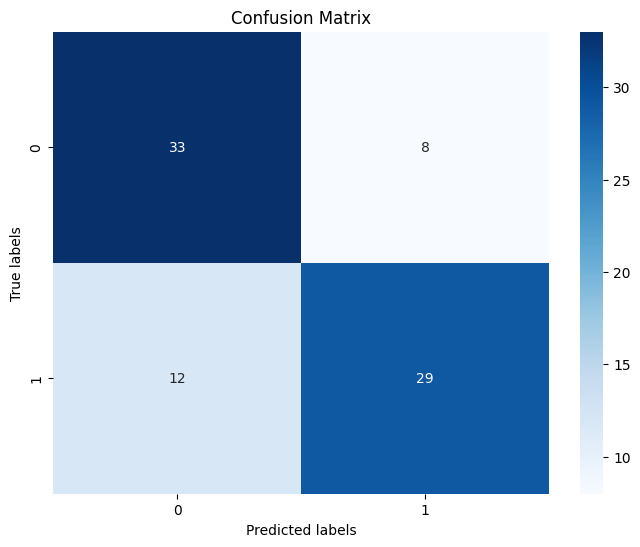

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

accuracy = accuracy_score(true_labels, predictions)
print(f"Acurácia do modelo: {accuracy:.2f}")

# Calcular a precisão
precision = precision_score(true_labels, predictions)
print(f"Precisão do modelo: {precision:.2f}")

# Calcular o recall
recall = recall_score(true_labels, predictions)
print(f"Recall do modelo: {recall:.2f}")

# Calcular o F1-score
f1 = f1_score(true_labels, predictions)
print(f"F1-score do modelo: {f1:.2f}")

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(true_labels, predictions)
print("Matriz de Confusão:")
print(conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
predictions

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1]

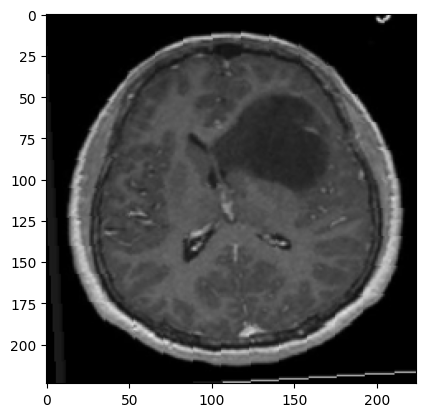

In [ ]:
images, labels = next(iter(augmented_dataloader))
image = transforms.ToPILImage()(images[8])
plt.imshow(np.array(image))

In [ ]:


import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Carregando o arquivo .npz
path = f"gdrive/MyDrive/Dados/Ex06/Brain_Tumor_Dataset/"

path_train_0 = path + "train"+"/health"
path_train_1 = path + "train"+"/tumor"

path_val_0 = path + "val"+"/health"
path_val_1 = path + "val"+"/tumor"

path_test = path + "test"


train_image_1 = []
train_image_4 = []

val_image_1 = []
val_image_4 = []

test_image_1 = []
test_image_4 = []

'''
list_files = os.listdir(path_train_0)
for i, file in enumerate(list_files):
  print(file)
f = mpimg.imread(path+'retina.tif')
f_data = np.asarray(f)
'''
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        #print(filename)
        #img = cv2.imread(os.path.join(folder,filename))
        img = mpimg.imread(os.path.join(folder,filename))
        #img = np.asarray(img)
        img = cv2.resize(img, target_size)
        if img is not None:
            images.append(img)
    return images


target_size = (224, 224)

#print(load_images_from_folder(path_train_0))
all_train_img_0 = load_images_from_folder(path_train_0)
all_train_img_1 = load_images_from_folder(path_train_1)

all_val_img_0 = load_images_from_folder(path_val_0)
all_val_img_1 = load_images_from_folder(path_val_1)


print(len(all_train_img_0))
print(len(all_train_img_1))

print(len(all_val_img_0))
print(len(all_val_img_1))


#plt.title('Imagem original')
#plt.imshow(all_train_img_0[0],cmap='gray')
#plt.axis('off')]
#print(np.array(all_train_img_0))



53
90
21
41


In [ ]:
'''
Devido ao desbalanceamento dos conjuntos de dados de treino, validação e teste,
optei por utilizar uma técnica chamada data augmentation para lidar com esse problema.
Essa abordagem envolve aplicar transformações artificiais às imagens do conjunto de dados
original, com o objetivo de aumentar sua diversidade e quantidade. Isso permite que o modelo
aprenda características mais robustas e generalizáveis, especialmente em conjuntos de dados
pequenos ou desbalanceados. Para este exercício específico, escolhi aplicar as transformações
 de rotação, espelhamento (flip) e recorte aleatório (random crop).
'''


import cv2
import numpy as np
from PIL import Image
from scipy.ndimage import rotate
from scipy.ndimage import zoom
from skimage.transform import resize


'''
É importante mencionar que, para evitar possíveis artefatos nas bordas ao aplicar
a rotação, optei por realizar a rotação das imagens apenas em ângulos
específicos, como 90°, 180° e 270°, de forma aleatória.
'''
angles = [90, 180, 270]

# Função para aplicar rotação aleatória em uma imagem
def rotate_image(image):
    #rotated_image = rotate(image, angles[np.random.randint(0, 3)], reshape=False)
    rotated_image = rotate(image, np.random.randint(0, 360), reshape=False)
    return rotated_image


# Função para aplicar espelhamento horizontal em uma imagem
def flip_image(image):
    if np.random.rand() < 0.5:
        flipped_image = np.flip(image, axis=1)  # Espelha horizontalmente
    else:
        flipped_image = np.flip(image, axis=0)  # Espelha verticalmente
    return flipped_image

def resize_image(image, target_size):
    # Redimensiona a imagem para o tamanho desejado
    resized_image = np.array(Image.fromarray(image).resize(target_size))

    return resized_image


def random_crop(image, crop_size):
    # Obtém as dimensões da imagem original
    original_height, original_width = image.shape[:2]

    # Obtém as dimensões do corte
    crop_height, crop_width = (crop_size, crop_size)

    # Calcula os limites para o corte
    max_y = original_height - crop_height
    max_x = original_width - crop_width

    # Escolhe aleatoriamente a posição do corte
    start_y = np.random.randint(0, max_y)
    start_x = np.random.randint(0, max_x)

    # Realiza o corte na imagem
    cropped_image = image[start_y:start_y+crop_height, start_x:start_x+crop_width]
    original_size = (original_height, original_width)  # (largura, altura)

    # Redimensiona o corte para o tamanho original
    resized_cropped_image = resize_image(cropped_image, original_size)
    return resized_cropped_image
'''
   num_images: Número de imagens aumentadas a serem geradas
   rand_img: Define o intervalo máximo de imagens que a função rand irá escolher aleatoriamente
   _images_: Define o conjunto de imagens na qual irá ser aplicada a augmentação
   '''
def gen_img(num_images, rand_img, _images_):

  # Lista para armazenar as imagens aumentadas
  augmented_images = []

  # Contador para controlar o número de imagens geradas
  generated_images_count = 0

  # Loop até que o número desejado de imagens seja gerado
  while generated_images_count < num_images:
      # Escolher uma imagem aleatória do array original_images
      n = np.random.randint(0, rand_img)
      #n = 0
      original_image = (_images_[n])
      #print(original_image)
      #original_image = (_images_[n])

      # Aplicar aumentos de dados na imagem escolhida
      augmented_image = rotate_image(original_image)
      #augmented_image = random_crop(augmented_image, 18)
      augmented_image = flip_image(augmented_image)
      #print(augmented_image.shape)
      # Armazenar a imagem aumentada na lista
      augmented_images.append(augmented_image)
      #print(augmented_image)

      # Incrementar o contador de imagens geradas
      generated_images_count += 1
  return augmented_images


# Converter a lista de imagens aumentadas em um array numpy
augmented_train_images = np.array(gen_img(2, 53, all_train_img_0))
#augmented_val_images = np.array(gen_img(20, 21, all_val_img_0))
#augmented_val_images = ap.array(gen_img(20, 21, all_val_img_0))



TypeError: Invalid shape (3, 224, 224) for image data

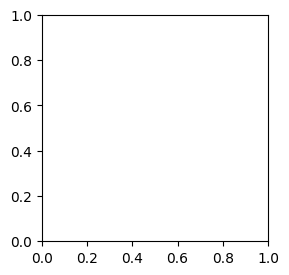

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2)])

image = tf.expand_dims(images[1], 0)
plt.figure(figsize=(10, 10))

for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")



In [ ]:
(augmented_train_images)



[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 

In [ ]:
train_image_1 = np.array(train_image_1)

train_image_1_full = np.concatenate((all_train_img_0, augmented_train_images), axis=0)

#val_image_1 = np.array(val_image_1)

#val_image_1_full = np.concatenate((val_image_1, augmented_val_images), axis=0)





'''
Após realizar o aumento de imagens para os conjuntos de treino 'train_image_1', validação
'val_image_1' e teste 'test_image_1', conforme explicado anteriormente, o próximo passo é
concatenar as imagens aumentadas dos conjuntos de treino, validação e teste associadas ao
rótulo 1 com as imagens correspondentes dos conjuntos de treino, validação e teste do rótulo 4.
'''
train_image = np.concatenate((train_image_1_full, train_image_4), axis=0)

#val_images = np.concatenate((val_image_1_full, val_image_4), axis=0)

print('Shape imagens treino:',(train_image.shape))
#print('Shape imagens validação:',(val_images.shape))
#print('Shape imagens teste:',(test_images.shape))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (53,) + inhomogeneous part.

In [ ]:
image=np.array(augmented_train_images[25])
print(image.shape)


(213, 236, 3)


(-0.5, 235.5, 212.5, -0.5)

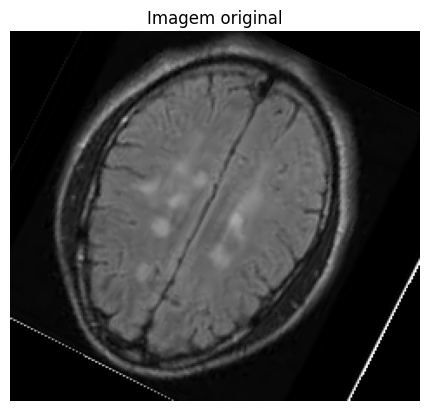

In [ ]:
plt.title('Imagem original')
plt.imshow(augmented_train_images[25],cmap='gray')
plt.axis('off')

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
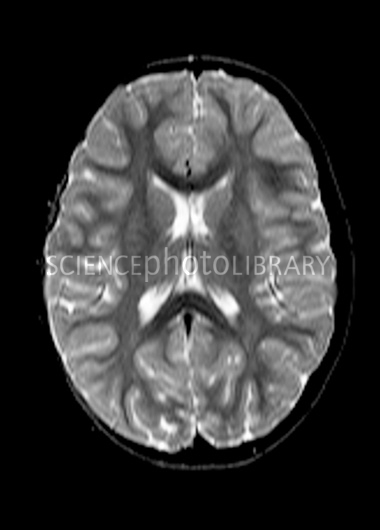

In [ ]:
all_train_img_0[25]

In [ ]:
[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),

 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
        [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8)]

NameError: name 'array' is not defined

In [ ]:
from torchvision import transforms

class CustomAugment(object):
    def __init__(self, augmentations):
        self.augmentations = augmentations
        self.augm_data = []
    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if label == 0:
            image = self.augmentations(image)

        return image, label

# Defina suas augmentações aqui
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(80),
    # Adicione mais se necessário
])

transform = transforms.Compose([
    # Outras transformações que se aplicam a todas as imagens
    CustomAugment(augmentations),
    # Transformações adicionais, se necessário
])

dataset = datasets.ImageFolder(root=train_data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
images, labels = next(iter(dataloader))


TypeError: 'Image' object is not subscriptable

In [ ]:
def show_image(dataset, size):
  data_loader = DataLoader(dataset, batch_size=size, shuffle=True)
  # Itera sobre o primeiro lote de dados 'data_loader'
  images, labels = next(iter(data_loader))

  print("Shape do batch:", images.shape)
  img_grid = make_grid(images, nrow=10, pad_value=1)
  fig = plt.figure(figsize=(10,10))
  plt.imshow(img_grid.permute(1, 2, 0).numpy())
  plt.title(f'Labels: {labels}')
  plt.axis('off')
  plt.show()


show_image(dataset, 10)

TypeError: 'Image' object is not subscriptable